In [1]:
from lxml import etree, objectify
import matplotlib.pyplot as plt
import numpy as np
import csv

FILENAME = "taganrog.xml"

with open(FILENAME) as f:
    xml = f.read()
    
root = objectify.fromstring(xml)

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
road = []           #текущий массив
roads = []          #массив с дорогами, в каждой дороге указаны узлы

way = root.way
for row in way:     #проход по каждой дороге
    tag = row.find("tag")
    if not (tag is None) and tag.attrib['k'] == 'highway':
        nd = row.nd          #список узлов
        for ref in nd:       #пробег по каждому узлу
            road.append(int(ref.attrib['ref']))
        roads.append(road)
        road = []

In [3]:
node = root.node             #список всех узлов

#словарь, по номеру узла выдает координаты
nodes = {int(row.attrib['id']): [float(row.attrib['lat']), float(row.attrib['lon'])] for row in node}

In [4]:
#словарь, в котором номеру узла соответствует количество его вхождений в дороги
count_node_in_roads = {int(row.attrib['id']): 0 for row in node}

for road in roads:
    for nd in road:
        count_node_in_roads[int(nd)] = count_node_in_roads[int(nd)] + 1
        
#словарь, в котором номеру узла соответствует количество ребер ему инцидентных 
count_edge_in_roads = {int(row.attrib['id']): 0 for row in node}
for road in roads:
    for i in range(len(road) - 1):
        count_edge_in_roads[road[i]] = count_edge_in_roads[road[i]] + 1
        count_edge_in_roads[road[i + 1]] = count_edge_in_roads[road[i + 1]] + 1
        
#массив необходимых к удалению узлов
nodes_to_delete = []
for nd in nodes:
    if count_node_in_roads[nd] == 0 or (count_node_in_roads[int(nd)] == 1 and count_edge_in_roads[int(nd)] == 2):
        nodes_to_delete.append(nd)
    
#удаление лишних узлов
for nd in nodes_to_delete:
    nodes.pop(nd)

In [5]:
#словарь списка смежности
list_adj = {nd:[] for nd in nodes}

row = []

for road in roads:
    for nd in road:
        if nd in nodes:        #если узел в этой дороге не лишний, записываем в текущую строку
            row.append(nd)
    for i in range(len(row) - 1):   #две соседние точки в троке образуют ребро, запишем это в список
        list_adj[row[i]].append(int(row[i+1]))
        list_adj[row[i+1]].append(int(row[i]))
    row = []
    
#убираем повторения в списке смежности
for key in list_adj:
    list_adj[key] = list(set(list_adj[key]))
    
    

In [6]:
#выбираем больницы
hospitals = {}

for nd in node:     #проход по каждому узлу
    tag = nd.find("tag")
    if not (tag is None) and tag.attrib['v'] == 'hospital':
        hospitals[int(nd.attrib['id'])] = [float(nd.attrib['lat']), float(nd.attrib['lon'])]
        
print len(hospitals)

8


In [7]:
#ищем ближайшие к больницам узлы на дорогах
import math

target = []
for h in hospitals:
    min_w = 10000
    nd_min = 0
    for nd in nodes:
        w = math.sqrt((nodes.get(nd)[0] - hospitals.get(h)[0])**2 + (nodes.get(nd)[1] - hospitals.get(h)[1])**2)
        if w < min_w:
            min_w = w
            nd_mai = nd
    target.append(nd_mai)
    
print target      

[1130256950, 1499967459, 3975857985, 211530735, 3898358242, 5422015747, 479475678, 3806624937]


In [8]:
#интерфейс для ввода координат

def Input_lon():
    print ('введите долготу между 38.84 и 38.96')
    global lon
    lon = input()
    if lon < 38.84  or lon > 38.96:
        print ('введите долготу заново')
        Input_lon()
        
def Input_lat():
    print ('введите широту между 47.20 и 47.28')
    global lat
    lat = input()
    if lat < 47.20 or lat > 47.28:
        print ('введите широту заново')
        Input_lat()
        
Input_lon()
Input_lat()
# 47.261885 
# 38.908703

#3 задание - координаты склада центрального рынка
# 38.91554
# 47.21275

введите долготу между 38.84 и 38.96
38.91554
введите широту между 47.20 и 47.28
47.21275


In [9]:
#ищем ближайшую к введенной координате точку на дороге
min_w = 1000000
for nd in nodes:
    w = math.sqrt((nodes.get(nd)[0] - lat)**2 + (nodes.get(nd)[1] - lon)**2)
    if w < min_w:
        min_w = w
        start = nd

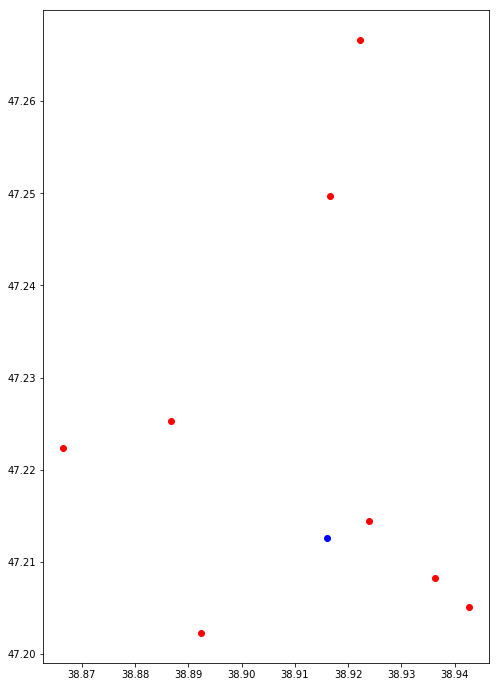

In [10]:
fig = plt.gcf()
fig.set_size_inches(8, 12)    #установка большого размера полотна
Lon_Lat = []

# for key in list_adj:
#     for nd in list_adj[key]:
#         plt.plot([nodes[key][1],nodes[nd][1]], [nodes[key][0],nodes[nd][0]], 'blue')

for h in hospitals:
    plt.plot(hospitals.get(h)[1], hospitals.get(h)[0], 'ro')
plt.plot(nodes.get(start)[1], nodes.get(start)[0],  'bo')

plt.show()

In [11]:
#Алгоритм Левита
from collections import deque

def Levita(a, b):
    len_sh_way = {nd: 1000000 for nd in nodes} # вершине соответствует длина пути до нее 
    len_sh_way.update({a: 0})
    
    shortest_way = {nd: [] for nd in nodes} #кратчайший путь от вершины a
    shortest_way.update({a: [a]})
    
    nodes_already_calc = [] # M0
    common_queue = deque((a,))       # M1'
    rush_queue = deque()         # M1''
    
    nodes_not_calc = [nd for nd in nodes] # M2
    nodes_not_calc.remove(a)
    
    cur_node = a
    
    while(len(common_queue) > 0 or len(rush_queue) > 0):
        if len(rush_queue) > 0:
            cur_node = rush_queue.popleft()
        else:
            cur_node = common_queue.popleft()
             
        adj = list_adj.get(cur_node)
        
        for nd in adj:
            w = math.sqrt((nodes.get(nd)[0] - nodes.get(cur_node)[0])**2 + (nodes.get(nd)[1] - nodes.get(cur_node)[1])**2)
           
            if nodes_not_calc.count(nd) > 0:
                common_queue.append(nd)
                nodes_not_calc.remove(nd)
                
                if len_sh_way.get(nd) > len_sh_way.get(cur_node) + w:
                    
                    len_sh_way.update({nd: len_sh_way.get(cur_node) + w})
                    way = shortest_way.get(cur_node)[:]
                    way.append(nd)
                    shortest_way.update({nd: way})
                          
                
            elif common_queue.count(nd) > 0 or rush_queue.count(nd) > 0:
                if len_sh_way.get(nd) > len_sh_way.get(cur_node) + w:
                    
                    len_sh_way.update({nd: len_sh_way.get(cur_node) + w})
                    way = shortest_way.get(cur_node)[:]
                    way.append(nd)
                    shortest_way.update({nd: way})
                    
            elif nodes_already_calc.count(nd) > 0 and len_sh_way.get(nd) > len_sh_way.get(cur_node) + w:
                
                rush_queue.append(nd)
                nodes_already_calc.remove(nd)
                
                len_sh_way.update({nd: len_sh_way.get(cur_node) + w})
                way = shortest_way.get(cur_node)[:]
                way.append(nd)
                shortest_way.update({nd: way})        
                          
        nodes_already_calc.append(cur_node)     
                          
    return(shortest_way.get(b))


In [ ]:
#отрисовка в matplotlib для моих алгоритмов

def PlotResult(a, b, way):
    fig = plt.gcf()
    fig.set_size_inches(8, 12)    #установка большого размера полотна
    Lon_Lat = []

    #общая карта
#     for key in list_adj:
#         for nd in list_adj[key]:
#             plt.plot([nodes[key][1],nodes[nd][1]], [nodes[key][0],nodes[nd][0]], 'blue')

    #граничные узлы
    plt.plot(nodes.get(a)[1], nodes.get(a)[0], 'ro')
    plt.plot(nodes.get(b)[1], nodes.get(b)[0], 'ro')

    #путь
    for nd in way:                 #проход по узлам найденного пути
        Lon_Lat.append([nodes.get(nd)[1], nodes.get(nd)[0]])
    Lon_Lat = np.array(Lon_Lat)   
    plt.plot(Lon_Lat[::, 0], Lon_Lat[::, 1], 'red')
    Lon_Lat = []


    plt.show()
    

In [12]:
#граф в networkx
import networkx as nx

GG = nx.Graph()

# добавляем узлы в граф
for key in nodes:
    GG.add_node(str(key),pos=tuple(nodes.get(key)))

# добавляем ребра в граф
for nd in list_adj:
    for nod in list_adj.get(nd):
        w = math.sqrt((nodes.get(nd)[1] + nodes.get(nod)[1])**2 + (nodes.get(nd)[0] + nodes.get(nod)[0])**2)
        GG.add_edge(str(nd),str(nod),weight=w)
                
#словарь узлов для networkx
nodesi = {str(key): [nodes.get(key)[1], nodes.get(key)[0]] for key in nodes}

In [ ]:
#отрисовка графа в networkx
def DrawGraph():
    nx.draw_networkx(GG, pos=nodesi, node_size = 0.1, width = 0.2, with_labels = False)
    plt.axis('on')
    plt.show()

In [ ]:
#отрисовка в networkx кратчайшего пути

def DrawSaveShortestWay(GG, way, start, end):
    nx.draw_networkx(GG, pos=nodesi, node_size = 0, width = 0.2, with_labels = False, node_color='black', edge_color='black')
    h = GG.subgraph(way)
    nx.draw_networkx_nodes(h,pos=nodesi, node_color='red', node_size = 2) 
    nx.draw_networkx_edges(h,pos=nodesi, edge_color='red', width = 2)
    fig = plt.gcf()
    fig.set_size_inches(8, 12)
    plt.show()
    filename = "ShortestWay__" + str(start) + "__" + str(end) + ".png"
    plt.savefig(filename, dpi = 100)
    fig.clear()


In [ ]:
#запись получисшихся маршрутов в файл

def WriteCsvFile(start, target, way):
    filename =  "ShortestWay__" + str(start) + "__" + str(target) + ".csv"
    with open(filename, "a") as file:
        writer = csv.writer(file)
        writer.writerow(way)

In [ ]:
#маршруты до больниц с записью в файл и сохранением картинок

for t in target:
    Dejicstra = nx.dijkstra_path(GG, str(start), str(t))
    DrawSaveShortestWay(GG, Dejicstra, str(start), str(t))
    WriteCsvFile(str(start), str(t), Dejicstra)

In [ ]:
#записываем в файл среднее время проезда до 100 вершин

import csv
import math

#считываем с файла узлы
filename =  "Statistics__100__points" + ".csv"

node100 = []
with open(filename, "r") as file:
    reader = csv.reader(file)
    for row in reader:
        node100.append(row[0])
        
    
filename =  "TimeWay__100__points" + ".csv"

#шапочка файла
fieldnames = ['idNode', 'time']

#запись шапочки
with open(filename, "w") as file:
    writer = csv.DictWriter(file, delimiter=',', fieldnames=fieldnames)
    writer.writeheader()
    
def csv_writer(path, fieldnames, data):
    with open(path, "a") as out_file:
        writer = csv.DictWriter(out_file, delimiter=',', fieldnames=fieldnames)
        for row in data:
            writer.writerow(row)

# для всех этих узлов получаем кратчайший путь, рассчитываем его длину и умножаем на километраж градусов по широте и долготе            
for nd in node100[1:]:
    way = Levita(start, int(nd));
    len_way_km = 0
    for i in range(len(way)-1):
        nd_1 = nodes.get(way[i])
        nd_2 = nodes.get(way[i + 1])
        len_way_km = len_way_km +  math.sqrt(((nd_1[0] - nd_2[0])**2)*76057 + ((nd_1[1] - nd_2[1])**2)*111000)
    time = len_way_km/40
    line = []
    line_dict = []
    line = [nd, time]
    inner_dict = dict(zip(fieldnames, line))
    line_dict.append(inner_dict)
    csv_writer(filename, fieldnames, line_dict)

In [13]:
#гамильтонов цикл минимального веса поиском ближайшего соседа
from heapq import heappush, heappop

hamilton = [start]   #цикл
way_between = {nd:[] for nd in target}

way_to = []     #дороги до текущего элемента cur_way
to = [nd for nd in target]

cur_way = 0
len_cur_way = 0

for useless in range(len(hospitals)):
    
    for nd in to:
        cur_way = nx.dijkstra_path(GG, str(start), str(nd))
        len_cur_way = 0
        for i in range(len(cur_way)-1):
            nd_1 = nodes.get(int(cur_way[i]))
            nd_2 = nodes.get(int(cur_way[i + 1]))
            len_cur_way = len_cur_way +  math.sqrt((nd_1[0] - nd_2[0])**2 + (nd_1[1] - nd_2[1])**2)

        heappush(way_to, (len_cur_way, nd, cur_way))   #добавляем длину кратчайшего пути для вершины nd от текущей start
    
    next_node = heappop(way_to)[1]        #забираем вершину с минимальным весом
    to.remove(next_node)                  #удаляем ее из списка еще не посещенных
    hamilton.append(next_node)            #добавляем в цикл
    start = next_node                     #теперь считать кратчайшие пути будем от нее
    way_to = []
    
    
print hamilton

[1127283057, 211530735, 1130256950, 3898358242, 3975857985, 1499967459, 3806624937, 479475678, 5422015747]


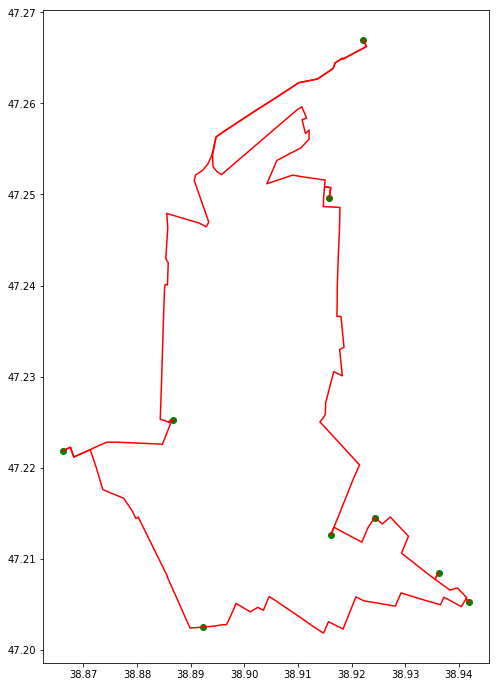

In [14]:
fig = plt.gcf()
fig.set_size_inches(8, 12)    #установка большого размера полотна
Lon_Lat = []

all_way = []
#путь
for i in range(len(hamilton) - 1):
    all_way.append(nx.dijkstra_path(GG, str(hamilton[i]), str(hamilton[i+1])))
all_way.append(nx.dijkstra_path(GG, str(hamilton[0]), str(hamilton[-1])))
    
for nd in hamilton:
    plt.plot(nodes.get(nd)[1], nodes.get(nd)[0], 'go')
    
for way in all_way:
    for nd in way:                 #проход по узлам найденного пути
        Lon_Lat.append([nodes.get(int(nd))[1], nodes.get(int(nd))[0]])
    Lon_Lat = np.array(Lon_Lat)   
    plt.plot(Lon_Lat[::, 0], Lon_Lat[::, 1], 'red')
    Lon_Lat = []

plt.show()
plt.savefig("hamilton_my.png",dpi = 100)

In [15]:
#решение задачи коммивояжера методом добавления вершины в цикл

#записываем все вершины для цикла
node_to = [nd for nd in target]
node_to.append(start)
hamilton = list(tuple(node_to))
size = len(node_to)  #количество вершин в графе

#вес ребра
def lenght_edge(i, j):
    l = math.sqrt((nodes.get(int(i))[0] - nodes.get(int(j))[0])**2 + (nodes.get(int(i))[1] - nodes.get(int(j))[1])**2)
    return l

#длина маршрута между двумя точками в исходном графе
def weight_way(way):
    w = 0
    for i in range(len(way) - 1):
        w = w + lenght_edge(way[i], way[i+1])
    return w

#словарь, по ребру выдает его вес
edges = {}
for i in node_to:
    for j in node_to:
        t = tuple([i,j])
        way = nx.dijkstra_path(GG, str(i), str(j))   #путь между этими вершинами в исходном графе
        edges[t] = weight_way(way)  #его длина

min_weight = 1000000;
min_edge = () #ребро с минимальным весом, ищем для старта

for key in edges:
    if edges.get(key) < min_weight and edges.get(key)!=0 :
        min_weight = edges.get(key)
        min_edge = key
        
#чтобы было потом удобно искать по ребрам, устанавливаем порядок очередности вершин, от меньшей к большей
if min_edge[0] > min_edge[1]:
    min_edge = ((min_edge[1],min_edge[0]))
    
#удаляем из списка необходимых к посещению вершин те, которые образуют кратчайшее ребро
node_to.remove(min_edge[0])    
node_to.remove(min_edge[1])    


cicle_edge = []    #цикл, записанный ребрами
cicle_node = []    #вершины в цикле
cicle_edge.append(min_edge)  
cicle_node.append(min_edge[0])
cicle_node.append(min_edge[1])

    
#вес цикла, на вход поступают имеющийся цикл, вершина, которую хотим добавить, ребро, которое хотим удалить
def lenght_way(cicle_ed, nd, ed):
    w = 0
    w = w + edges.get((ed[0], nd)) #добавляем ребро с новой вершиной из одного конца ребра
    w = w + edges.get((ed[1], nd)) #из другого
    for nod in cicle_ed:
        w = w + edges.get(nod)     #прибавляем просто веса всех ребер в этом цикле
    w = w - edges.get(ed)          #вычитаем вес того, вместо которого добавляли новые
    return w;
    
#из-за наличия стартового ребра, проходим циклом n-2 раза по точкам графа
for useless in range(size - 2):
    min_w_cicle = 1000000
    ed_to_remove = ()
    nd_to_add = 0
    #для вершин, которые еще не в цикле
    for nd in node_to:
        for ed in cicle_edge: #для ребер, которые уже в цикле сравниваем
            w = lenght_way(tuple(cicle_edge), nd, ed) #какое ребро будет выгоднее всего заменить двумя ребрами с новой вершиной
            if w < min_w_cicle:
                min_w_cicle = w
                ed_to_remove = ed
                nd_to_add = nd
        
    #снова располагаем в порядке возрастания координаты ребра для удобства удаления
    if ed_to_remove[0] < nd_to_add:
        cicle_edge.append((ed_to_remove[0], nd_to_add))
    else:
        cicle_edge.append((nd_to_add, ed_to_remove[0]))
        
    if ed_to_remove[1] < nd_to_add:
        cicle_edge.append((ed_to_remove[1], nd_to_add))
    else:
        cicle_edge.append((nd_to_add, ed_to_remove[1]))
       
    #удаляем старое ребро
    if useless != 0:
        cicle_edge.remove(ed_to_remove)
    #добавляем в список посещенных вершин новую
    cicle_node.append(nd_to_add)
    #удаляем из списка непосещенных новую
    node_to.remove(nd_to_add)

print cicle_edge

[(1130256950, 3898358242), (211530735, 1130256950), (3898358242, 3975857985), (1499967459, 3806624937), (1499967459, 3975857985), (211530735, 5422015747), (5422015747, 5422015747), (479475678, 3806624937), (479475678, 5422015747)]


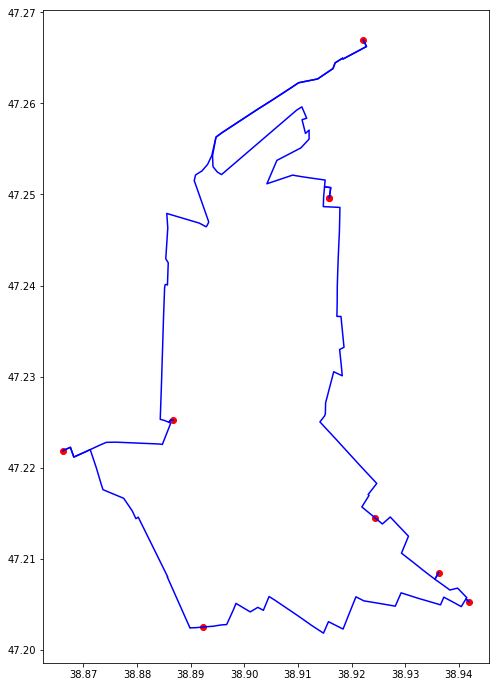

In [16]:
fig = plt.gcf()
fig.set_size_inches(8, 12)    #установка большого размера полотна
Lon_Lat = []

all_way = []
#путь
for t in cicle_edge:
    all_way.append(nx.dijkstra_path(GG, str(t[0]), str(t[1])))
    
for nd in hamilton:
    plt.plot(nodes.get(nd)[1], nodes.get(nd)[0], 'ro')
    
for way in all_way:
    for nd in way:                 #проход по узлам найденного пути
        Lon_Lat.append([nodes.get(int(nd))[1], nodes.get(int(nd))[0]])
    Lon_Lat = np.array(Lon_Lat)   
    plt.plot(Lon_Lat[::, 0], Lon_Lat[::, 1], 'blue')
    Lon_Lat = []

plt.show()
plt.savefig("hamilton_my_2.png",dpi = 100)